# Evaluate the Model

## Based Confusion Matrix, ROC_AUC Curve

In [1]:
from sklearn.metrics import confusion_matrix, classification_report      
from sklearn.metrics import roc_auc_score
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

from tensorflow.keras.applications.xception import Xception

import pandas as pd
import os
import itertools
from utils import plot_confusion_matrix


2.1.0


### Download the trained weights from my S3 bucket

In [2]:
#Download trained model from my S3 bucket
!wget https://covid19-hackathon.s3.us-east-2.amazonaws.com/weights.99-0.00.hdf5

--2020-05-07 10:56:23--  https://covid19-hackathon.s3.us-east-2.amazonaws.com/weights.99-0.00.hdf5
Resolving covid19-hackathon.s3.us-east-2.amazonaws.com (covid19-hackathon.s3.us-east-2.amazonaws.com)... 52.219.88.208
Connecting to covid19-hackathon.s3.us-east-2.amazonaws.com (covid19-hackathon.s3.us-east-2.amazonaws.com)|52.219.88.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889045112 (848M) [binary/octet-stream]
Saving to: ‘weights.99-0.00.hdf5’

weights.99-0.00.hdf 100%[===================>] 847.86M  9.37MB/s    in 85s     

2020-05-07 10:57:49 (10.0 MB/s) - ‘weights.99-0.00.hdf5’ saved [889045112/889045112]



In [3]:
checkpoint_path = 'weights.99-0.00.hdf5'

In [4]:
input_shape = (256,256,3)


In [5]:

def getModel():
    
    pretrained_model = Xception(input_shape = input_shape,
                weights = 'imagenet',
                layers=tf.keras.layers,
                include_top = False)
    pretrained_model.trainable = False
    
    for layer in pretrained_model.layers:
        layer.trainable = False
    
    model = Sequential()

    model.add(pretrained_model)

    model.add(Flatten())

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(3))
    model.add(Activation('softmax'))

    model.summary()
    return model

In [6]:
model = getModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               67109376  
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0

### Load downloaded weights

In [7]:
model.load_weights(checkpoint_path)

In [8]:

# train_datagen = ImageDataGenerator(rescale=1/255)
# val_datagen = ImageDataGenerator(rescale=1/255)

# normalize images
train_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization= True)
    
validation_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization= True)
target_size = (256,256)

In [9]:
df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'train.csv'))
df

,Unnamed: 0,filename,label
0,201,05ee72bf-6d12-4ac5-a47e-f43a7ea52a40.jpg,0
1,2545,3282f02d-965e-4da5-acf7-b3d8e8154a31.jpg,2
2,2293,3036fb15-305b-4e9b-93ab-4e555a0fd323.jpg,2
3,1095,0cb23e5a-a46a-4a32-89c0-8030941b6301.jpg,0
4,500,0821dd8e-16f7-4931-ac86-37a6cb40df84.jpg,0
...,...,...,...
953,867,0b00fd58-8071-4e60-b9fc-00bc3cd4ab26.jpg,0
954,5,nejmc2001573_f1b.jpeg,1
955,3920,3b84f97b-fa88-424a-891c-e57c3b92c062.jpg,2
956,3433,3858239f-f7ce-4858-94fb-095174a6c0e8.jpg,2


In [10]:
val_df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'test.csv'))
val_df

,Unnamed: 0,filename,label
0,287,covid-19-pneumonia-22-day1-pa.png,1
1,1006,0c066cf2-d552-4843-b613-38a8bddddcd2.jpg,0
2,305,06bc1519-c307-4a98-b00b-8329f2ddf615.jpg,2
3,250,covid-19-caso-70-1-PA.jpg,1
4,3036,35ab0be2-1772-4ef7-b8f9-45e5e371ac11.jpg,2
...,...,...,...
102,1076,0c860336-135a-4eed-9269-105f65dc9a4d.jpg,0
103,291,covid-19-pneumonia-38-pa.jpg,1
104,48,01b56434-4dd9-4994-bcc5-0b70a36e415a.jpg,0
105,747,09f0d4b9-acf6-4e2d-9a1a-5af5734bd96b.jpg,0


In [11]:
batch_size = 128

In [12]:
# train_data_gen = train_datagen.flow_from_directory(train_path,
#                                                target_size=target_size,
#                                                batch_size=32,
#                                                class_mode='categorical')

image_dir =os.path.join(os.getcwd(), 'data','train')
train_generator = train_datagen.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col='filename',
            y_col='label',
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            #seed=seed,
            target_size=target_size)

val_image_dir =os.path.join(os.getcwd(), 'data','test')
test_generator = train_datagen.flow_from_dataframe(
            dataframe=val_df,
            directory=val_image_dir,
            x_col='filename',
            y_col='label',
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            #seed=seed,
            target_size=target_size)

Found 958 validated image filenames.
Found 107 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


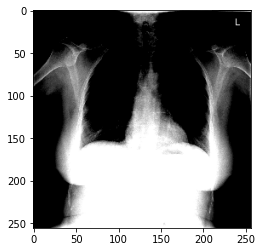

In [13]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

In [14]:
#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
# predicted_labels = model.evaluate_generator(train_generator,
#                         steps=train_generator.samples/train_generator.batch_size)

In [16]:
predicted_labels = model.predict(train_generator,
                        steps=train_generator.samples/train_generator.batch_size)

In [17]:
predicted_labels.shape

(958, 3)

In [18]:
predicted_labels

array([[9.99998093e-01, 2.65854169e-07, 1.68617987e-06],
       [1.54155481e-04, 2.34513550e-06, 9.99843478e-01],
       [8.98213184e-05, 5.63309044e-08, 9.99910116e-01],
       ...,
       [7.68302765e-04, 1.65901625e-07, 9.99231577e-01],
       [3.74045630e-04, 5.63521745e-08, 9.99625921e-01],
       [6.76985510e-05, 1.36850115e-11, 9.99932289e-01]], dtype=float32)

In [19]:
predicted_probability = tf.nn.softmax(predicted_labels)

In [20]:
train_generator.labels.shape

(958,)

In [21]:
predicted_labels = tf.math.argmax(predicted_probability, axis=1).numpy()

In [22]:
true_labels = df['label']

In [23]:
true_labels[0:10]

0    0
1    2
2    2
3    0
4    0
5    2
6    0
7    2
8    0
9    0
Name: label, dtype: int64

In [24]:
predicted_labels[0:10]

array([0, 2, 2, 0, 0, 2, 0, 2, 0, 0])

In [25]:
classes = ['normal', 'COVID-19', 'other_pneumonia']

In [26]:
class_dict ={classes[i]: i for i in range(3)}

In [27]:
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion matrix")
print(cm)

Confusion matrix
[[397   0  10]
 [  5 121   2]
 [ 10   0 413]]


### Confusion Matrix

In [28]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       407
           1       1.00      0.95      0.97       128
           2       0.97      0.98      0.97       423

    accuracy                           0.97       958
   macro avg       0.98      0.97      0.97       958
weighted avg       0.97      0.97      0.97       958



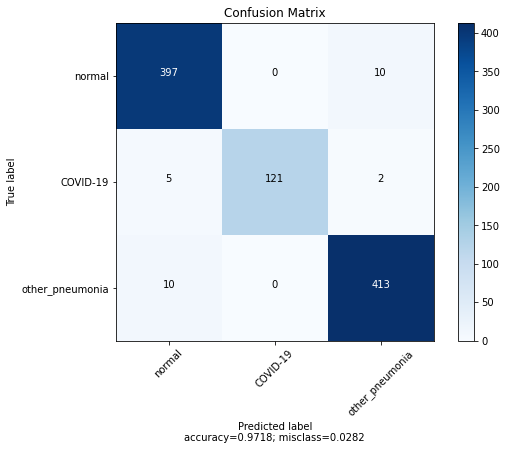

In [29]:
plot_confusion_matrix(cm, normalize    = False,
                      target_names = classes,
                      title        = "Confusion Matrix")

In [30]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from  sklearn.metrics import precision_recall_fscore_support

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
actuals = []
probabilities = []

In [32]:
predicted_probabilities = model.predict_generator(test_generator,
                        steps=test_generator.samples/test_generator.batch_size)

Instructions for updating:
Please use Model.predict, which supports generators.


In [33]:
predicted_probabilities.shape


(107, 3)

In [34]:
predicted_probabilities
predicted_probabilities = tf.nn.softmax(predicted_probabilities)

In [35]:
predicted_labels = tf.math.argmax(predicted_probabilities, axis=1).numpy()


In [36]:
predicted_labels

array([1, 0, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 1, 2, 2, 0,
       0, 0, 0, 2, 2, 0, 0, 1, 2, 2, 0, 1, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2,
       0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 1, 0, 2, 0, 0, 2, 0, 0, 1,
       0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 2, 1, 2, 0, 2, 2, 1, 0,
       0, 2, 1, 2, 2, 2, 0, 0, 2, 2, 1, 0, 0, 1, 0, 1, 0, 0, 0])

In [37]:
test_generator.labels

array([1, 0, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 0,
       0, 0, 0, 2, 2, 0, 0, 1, 2, 2, 0, 1, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2,
       0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 1, 0, 2, 0, 0, 2, 0, 0, 1,
       0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 2, 1, 2, 0, 2, 2, 1, 0,
       0, 2, 1, 2, 2, 2, 0, 0, 2, 2, 1, 0, 0, 1, 0, 1, 0, 0, 0])

In [38]:
def test_class_probabilities(model,  which_class):
    actuals = []
    probabilities = []
    
    predicted_logits = model.predict_generator(test_generator,
                        steps=test_generator.samples/test_generator.batch_size)
    
    #fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, predicted_labels)

    predicted_probabilities = tf.nn.softmax(predicted_logits)
    #print(predicted_probabilities)
    #predicted_labels = tf.math.argmax(predicted_probabilities, axis=1).numpy()
    
    actuals.extend(test_generator.labels == which_class)
    #probabilities.extend(np.exp(predicted_probabilities[:, which_class]))
    probabilities.extend(predicted_probabilities[:, which_class].numpy())
    return [i for i in actuals], [i for i in probabilities]
    
    
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.cuda(), target.cuda()
#             output = model(data)
#             prediction = output.argmax(dim=1, keepdim=True)
#             actuals.extend(target.view_as(prediction) == which_class)
#             output = output.cpu()
#             probabilities.extend(np.exp(output[:, which_class]))
#     return [i.item() for i in actuals], [i.item() for i in probabilities]

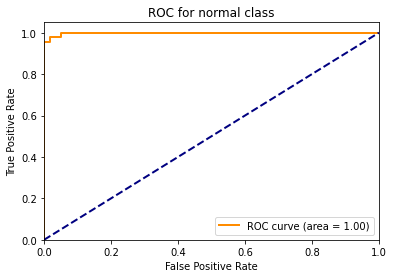

In [39]:
which_class = 0
actuals, class_probabilities = test_class_probabilities(model, which_class)
#print(actuals)
#print(class_probabilities)
fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for normal class')
plt.legend(loc="lower right")
plt.show()

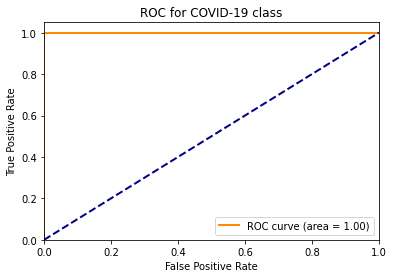

In [40]:
which_class = 1
actuals, class_probabilities = test_class_probabilities(model, which_class)

fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for COVID-19 class')
plt.legend(loc="lower right")
plt.show()

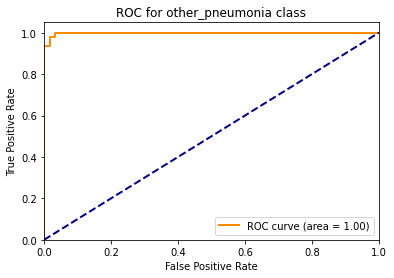

In [41]:
which_class = 2
actuals, class_probabilities = test_class_probabilities(model,  which_class)

fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for other_pneumonia class')
plt.legend(loc="lower right")
plt.show()